# Conditional GAN on MNIST

In [1]:
import tensorflow as tf
import numpy as np
from __future__ import division

## Data

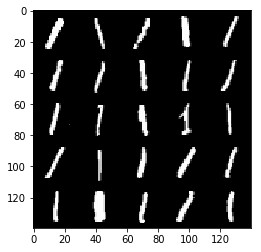

In [2]:
data_dir = './../data/mnist_png'

import sys
sys.path.insert(0, data_dir)

import helper

show_n_images = 25

%matplotlib inline
import os
from glob import glob
import matplotlib.pyplot as plt

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'train/*/*.png'))[:show_n_images], 28, 28, 'L')

plt.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

## Inputs

In [3]:
def model_inputs(img_w, img_h, img_channels, z_dim, n_classes=10):

    inputs_real = tf.placeholder(tf.float32, (None, img_w, img_h, img_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    
    inputs_label_image = tf.placeholder(tf.float32, (None, img_w, img_h, n_classes), name='inputs_label')
    inputs_label_z = tf.placeholder(tf.float32, (None, n_classes), name='inputs_label')

    return inputs_real, inputs_z, inputs_label_image, inputs_label_z

## Generator

In [4]:
def generator(z, labels, out_channels, is_train=True, alpha=0.2, momentum=0.8):
    
    with tf.variable_scope('Generator', reuse=not(is_train)):
            
        # attach label information to z 
        z_cond = tf.concat([z, labels], axis=1)
            
        # ? -> 7x7x256
        with tf.variable_scope('FC', reuse=not(is_train)):
            fc = tf.layers.dense(z_cond, 7*7*256, name='FullyConn')
            fc = tf.reshape(fc, (-1, 7, 7, 256), name='Reshape')
            fc = tf.layers.batch_normalization(fc, training=is_train, name='BatchNorm')
            fc = tf.nn.leaky_relu(fc, alpha, name='out')

        # 7x7x256 -> 14x14x128
        with tf.variable_scope('Conv_1', reuse=not(is_train)):
            conv1 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same', name="Conv2D")
            conv1 = tf.layers.batch_normalization(conv1, momentum=momentum, training=is_train, name='BatchNorm')
            conv1 = tf.nn.leaky_relu(conv1, alpha, name='out')

        # 14x14x128 -> 28x28x64
        with tf.variable_scope('Conv_2', reuse=not(is_train)):
            conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='same', name="Conv2D")
            conv2 = tf.layers.batch_normalization(conv2, momentum=momentum, training=is_train, name='BatchNorm')
            conv2 = tf.nn.leaky_relu(conv2, alpha, name='out')

        # 28x28x64 -> 28x28x(1 or 3)
        conv3 = tf.layers.conv2d_transpose(conv2, out_channels, 5, strides=1, padding='same', name="Conv_3")

        out = tf.tanh(conv3, name='out')
    
    return out

## Discriminator

In [5]:
def discriminator(images, labels, reuse=False, alpha=0.2, keep_prob=0.75, momentum=0.8):
    
    with tf.variable_scope('Discriminator', reuse=reuse):
        
        images_cond = tf.concat([images, labels], axis=3)
        
        with tf.variable_scope('Conv_1', reuse=reuse):
            conv1 = tf.layers.conv2d(images_cond, 64, 5, strides=2, padding='same', name="Conv2D")
            conv1 = tf.nn.leaky_relu(conv1, alpha, name='L-ReLU')
            conv1 = tf.nn.dropout(conv1, keep_prob, name='out')

        with tf.variable_scope('Conv_2', reuse=reuse):
            conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', name="Conv2D")
            conv2 = tf.nn.leaky_relu(conv2, alpha, name='L-ReLU')
            conv2 = tf.nn.dropout(conv2, keep_prob, name='Dropout')
            conv2 = tf.layers.batch_normalization(conv2, momentum=momentum, training=True, name='out')
    
        with tf.variable_scope('Conv_3', reuse=reuse):
            conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', name="Conv2D")
            conv3 = tf.nn.leaky_relu(conv3, alpha, name='L-ReLU')
            conv3 = tf.nn.dropout(conv3, keep_prob, name='Dropout')
            conv3 = tf.layers.batch_normalization(conv3, momentum=momentum, training=True, name='out')

        conv3_shape = conv3.get_shape().as_list()
        flatten_shape = conv3_shape[1] * conv3_shape[2] * conv3_shape[3]
        
        with tf.variable_scope('FC', reuse=reuse):
            flat = tf.reshape(conv3, (-1, flatten_shape), "Flatten")
            logits = tf.layers.dense(flat, 1, name='out')

        out = tf.sigmoid(logits, name='out')

    return out, logits

## Loss functions

In [6]:
def model_loss(input_image, input_z, input_label_image, input_label_z, out_channels, smooth=0.05):
    
    g = generator(input_z, input_label_z, out_channels)
    d_real, d_logits_real = discriminator(input_image, input_label_image)
    d_fake, d_logits_fake = discriminator(g, input_label_image, reuse=True)
    
    with tf.name_scope("Losses"):
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_fake)),
            name="G_Loss")

        with tf.name_scope("D_Loss") as scope:
            d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_real,
                    labels=tf.ones_like(d_real)*(1-smooth)),
                name="D_Loss_Real")
            d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake,
                    labels=tf.zeros_like(d_fake)+smooth),
                name="D_Loss_Fake")

            d_loss = (d_loss_real + d_loss_fake)/2
            d_loss = tf.identity(d_loss, name=scope)
    
    
    # Summaries
    tf.summary.scalar('g_loss', g_loss)
    tf.summary.scalar('d_loss_real', d_loss_real)
    tf.summary.scalar('d_loss_fake', d_loss_fake)
    tf.summary.scalar('d_loss', d_loss)

    tf.summary.image('g_images', g, 1)
    
    return g_loss, d_loss

In [7]:
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate, beta1, beta2=0.999):
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('Generator')]
    d_vars = [var for var in t_vars if var.name.startswith('Discriminator')]
    
    #print g_vars, d_vars # Cool to see the variables you have
    for var in t_vars:
        tf.summary.histogram(var.name[:-2], var) # [:-2] to remove ':0' from tensor name
    
    # Optimize
    with tf.name_scope("Optimizers"):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            g_train_opt = tf.train.AdamOptimizer(learning_rate=g_learning_rate,
                                                 beta1=beta1,
                                                 beta2=beta2, name='G_Adam').minimize(g_loss, var_list=g_vars)
            
            d_train_opt = tf.train.AdamOptimizer(learning_rate=d_learning_rate,
                                                 beta1=beta1,
                                                 beta2=beta2, name='D_Adam').minimize(d_loss, var_list=d_vars)
    
    return g_train_opt, d_train_opt

In [8]:
def show_generator_output(sess, n_images, input_z, input_label_z, out_channel_dim, image_mode, n_classes=10):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    example_labels = np.eye(n_classes)[np.arange(n_images)]

    samples = sess.run(
        generator(input_z, input_label_z, out_channel_dim, False),
        feed_dict={
            input_z: example_z,
            input_label_z: example_labels
        })

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [9]:
def train(epoch_count, batch_size, z_dim, g_learning_rate, d_learning_rate, beta1,
          get_batches, data_shape, data_image_mode, n_classes=10):
    
    input_real, input_z, input_label_image, input_label_z = model_inputs(data_shape[1], data_shape[2],
                                                                         data_shape[3], z_dim,
                                                                         n_classes) # placeholders
    g_loss, d_loss = model_loss(input_real, input_z, input_label_image, input_label_z, data_shape[3]) # loss
    g_opt, d_opt = model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate, beta1) # optimizers
    
    save_dir = '/tmp/dcgan/dcgan_mnist.ckpt'
    saver = tf.train.Saver()
    
    log_dir = '/tmp/dcgan/tb/mnist'
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(log_dir)
    
    steps = 0
    
    with tf.Session() as sess:
        
        writer.add_graph(sess.graph)
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images, batch_labels in get_batches(batch_size):
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_label_z = np.eye(n_classes)[batch_labels] # (None, n_classes)
                
                batch_label_image = np.expand_dims(np.expand_dims(batch_label_z, axis=1), axis=1) \
                    * np.ones([batch_size, data_shape[1], data_shape[2], n_classes]) # (None, 3, 3, n_classes)
                
                
                # Run optimizers
                _ = sess.run(g_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        input_label_image: batch_label_image,
                        input_label_z: batch_label_z
                    })
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        input_label_image: batch_label_image,
                        input_label_z: batch_label_z
                    })
                
                if steps % 20 == 0:
                    summary = sess.run(merged_summary, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        input_label_image: batch_label_image,
                        input_label_z: batch_label_z
                    })
                    writer.add_summary(summary, steps)
                    
                    #train_loss_d = sess.run(d_loss, feed_dict={
                    #    input_z: batch_z,
                    #    input_real: batch_images
                    #    })
                    #train_loss_g = sess.run(g_loss, feed_dict={
                    #    input_z: batch_z
                    #})
                    
                    #print("Epoch {}/{}...".format(epoch_i+1, epochs),
                    #      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                    #      "Generator Loss: {:.4f}".format(train_loss_g))
                    print "Epoch: {}, Steps: {}".format(epoch_i+1, steps)
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, input_label_z, data_shape[3],
                                          data_image_mode, n_classes)
        
        saver.save(sess, save_dir)

Epoch: 1, Steps: 20
Epoch: 1, Steps: 40
Epoch: 1, Steps: 60
Epoch: 1, Steps: 80
Epoch: 1, Steps: 100


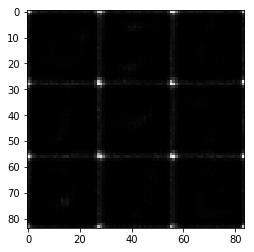

Epoch: 1, Steps: 120
Epoch: 1, Steps: 140
Epoch: 1, Steps: 160
Epoch: 1, Steps: 180
Epoch: 1, Steps: 200


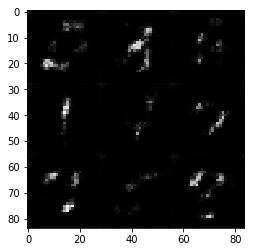

Epoch: 1, Steps: 220
Epoch: 1, Steps: 240
Epoch: 1, Steps: 260
Epoch: 1, Steps: 280
Epoch: 1, Steps: 300


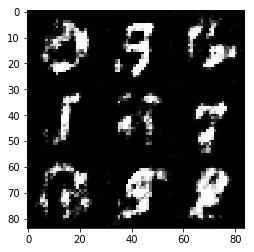

Epoch: 1, Steps: 320
Epoch: 1, Steps: 340
Epoch: 1, Steps: 360
Epoch: 1, Steps: 380
Epoch: 1, Steps: 400


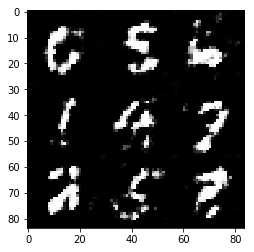

Epoch: 1, Steps: 420
Epoch: 1, Steps: 440
Epoch: 1, Steps: 460
Epoch: 1, Steps: 480
Epoch: 1, Steps: 500


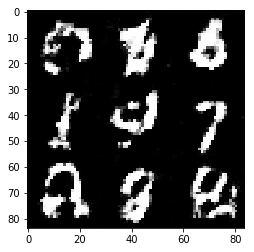

Epoch: 1, Steps: 520
Epoch: 1, Steps: 540
Epoch: 1, Steps: 560
Epoch: 1, Steps: 580
Epoch: 1, Steps: 600


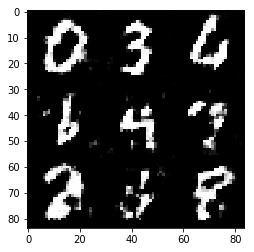

Epoch: 1, Steps: 620
Epoch: 1, Steps: 640
Epoch: 1, Steps: 660
Epoch: 1, Steps: 680
Epoch: 1, Steps: 700


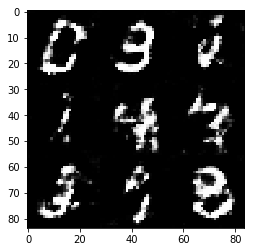

Epoch: 1, Steps: 720
Epoch: 1, Steps: 740
Epoch: 1, Steps: 760
Epoch: 1, Steps: 780
Epoch: 1, Steps: 800


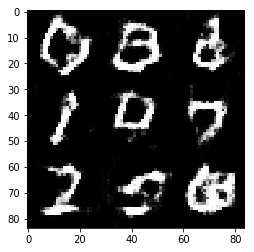

Epoch: 1, Steps: 820
Epoch: 1, Steps: 840
Epoch: 1, Steps: 860
Epoch: 1, Steps: 880
Epoch: 1, Steps: 900


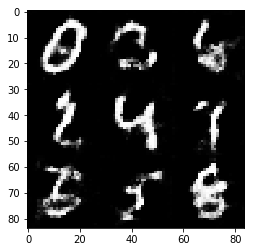

Epoch: 1, Steps: 920
Epoch: 2, Steps: 940
Epoch: 2, Steps: 960
Epoch: 2, Steps: 980
Epoch: 2, Steps: 1000


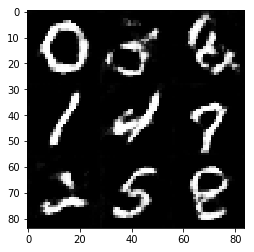

Epoch: 2, Steps: 1020
Epoch: 2, Steps: 1040
Epoch: 2, Steps: 1060
Epoch: 2, Steps: 1080
Epoch: 2, Steps: 1100


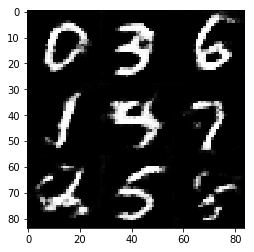

Epoch: 2, Steps: 1120
Epoch: 2, Steps: 1140
Epoch: 2, Steps: 1160
Epoch: 2, Steps: 1180
Epoch: 2, Steps: 1200


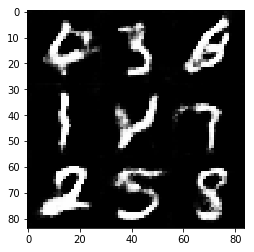

Epoch: 2, Steps: 1220
Epoch: 2, Steps: 1240
Epoch: 2, Steps: 1260
Epoch: 2, Steps: 1280
Epoch: 2, Steps: 1300


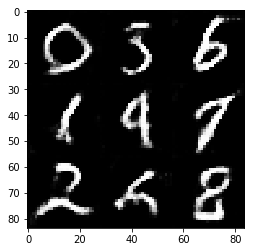

Epoch: 2, Steps: 1320
Epoch: 2, Steps: 1340
Epoch: 2, Steps: 1360
Epoch: 2, Steps: 1380
Epoch: 2, Steps: 1400


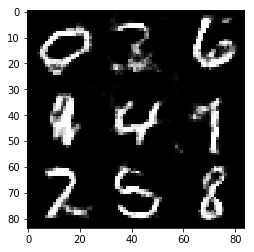

Epoch: 2, Steps: 1420
Epoch: 2, Steps: 1440
Epoch: 2, Steps: 1460
Epoch: 2, Steps: 1480
Epoch: 2, Steps: 1500


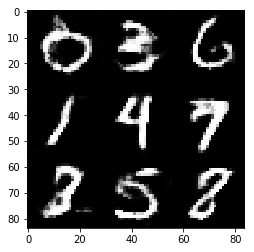

Epoch: 2, Steps: 1520
Epoch: 2, Steps: 1540
Epoch: 2, Steps: 1560
Epoch: 2, Steps: 1580
Epoch: 2, Steps: 1600


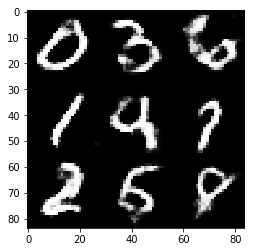

Epoch: 2, Steps: 1620
Epoch: 2, Steps: 1640
Epoch: 2, Steps: 1660
Epoch: 2, Steps: 1680
Epoch: 2, Steps: 1700


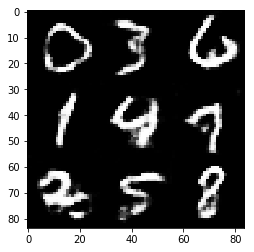

Epoch: 2, Steps: 1720
Epoch: 2, Steps: 1740
Epoch: 2, Steps: 1760
Epoch: 2, Steps: 1780
Epoch: 2, Steps: 1800


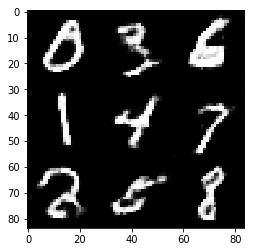

Epoch: 2, Steps: 1820
Epoch: 2, Steps: 1840
Epoch: 2, Steps: 1860


In [10]:
batch_size = 64
z_dim = 100
g_learning_rate = 0.0002
d_learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset(glob(os.path.join(data_dir, 'train/*/*.png')), 28, 28, 1)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, g_learning_rate, d_learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)